# Diff Mean Model
calculate difference of t and t-1 lev_l values
see also mean_model.ipynb

In [2]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
input_dir = '../input/'
working_dir = '../working/'
output_dir = '../output/'

## Read data

In [4]:
def read_track(line_name='a'):
    track_df = pd.read_csv(os.path.join(input_dir, 'track_{}.csv'.format(line_name.upper())))
    col_names_track = ['date', 'kilo', 'lev_l', 'lev_r', 'cur_l', 'cur_r', 'cant', 'width', 'speed']
    track_df.columns = col_names_track
    track_df['date'] = pd.to_datetime(track_df['date'])
    print('track_{line_name} shape: {shape}'.format(line_name=line_name.upper(), shape=track_df.shape))
    return track_df

In [5]:
def read_equ(line_name='a'):
    equ_df = pd.read_csv(os.path.join(input_dir, 'equipment_{}.csv'.format(line_name.upper())))
    col_names_equ = ['kilo', 'is_ballast', 'is_long', 'sleeper_type', 'is_bridge', 'is_crossing', 'gross_ton', 'radius', 'is_unreliable']
    equ_df.columns = col_names_equ
    print('equ_{line_name} shape: {shape}'.format(line_name=line_name.upper(), shape=equ_df.shape))
    return equ_df

In [6]:
abcd_list = ['a', 'b', 'c', 'd']
track = {}
equ = {}
for abcd in abcd_list:
    track[abcd] = read_track(abcd)
    equ[abcd] = read_equ(abcd)

track_A shape: (10185690, 9)
equ_A shape: (27906, 9)
track_B shape: (7815753, 9)
equ_B shape: (21531, 9)
track_C shape: (20324660, 9)
equ_C shape: (55684, 9)
track_D shape: (5601687, 9)
equ_D shape: (15691, 9)


In [7]:
sample_submit = pd.read_csv(os.path.join(input_dir, 'sample_submit.csv'), header=None)
index_master = pd.read_csv(os.path.join(input_dir, 'index_master.csv'))
index_master.columns = ['id', 'line_name', 'date', 'kilo']

## Calculate Diff

In [33]:
track_sorted = {}
lev_df = {}
lev_diff = {}
lev_diff_mean = {}
lev_nov_mean = {}
track_pred = {}
track_pred_concat = pd.DataFrame()
for abcd in abcd_list:
    # calculate diff
    lev_df[abcd] = track[abcd].pivot(index='date', columns='kilo', values='lev_l')
    lev_df[abcd] = lev_df[abcd].fillna(method='ffill')
    lev_diff[abcd] = lev_df[abcd].diff()
    # mean of diff
    lev_diff_mean[abcd] = lev_diff[abcd].mean(axis=0)
    lev_diff_mean[abcd] = lev_diff_mean[abcd].fillna(lev_diff_mean[abcd].mean())
    # mean of actual lev_l in November
    lev_nov_mean[abcd] = track[abcd].query('date>="20171201"').groupby('kilo')['lev_l'].mean()
    # pred equals "mean of Nov" + "mean of diff" 
    track_pred[abcd] = lev_nov_mean[abcd] + lev_diff_mean[abcd]
    track_pred[abcd].name = 'lev_l'
    track_pred[abcd] = track_pred[abcd].to_frame()
    track_pred[abcd]['line_name'] = abcd.upper()
    track_pred[abcd] = track_pred[abcd].reset_index()
    track_pred[abcd]['kilo'] = track_pred[abcd]['kilo'].astype('int')
    track_pred_concat = pd.concat([track_pred_concat, track_pred[abcd]], axis=0)

In [35]:
submit = pd.merge(index_master, track_pred_concat, how='left', on=['kilo', 'line_name'])
submit['lev_l'] = submit['lev_l'].fillna(submit['lev_l'].mean())

In [36]:
submit[['id', 'lev_l']].to_csv(os.path.join(output_dir, 'diff_mean_model_20181028.csv'), header=False, index=False)

# columtive mean of diff

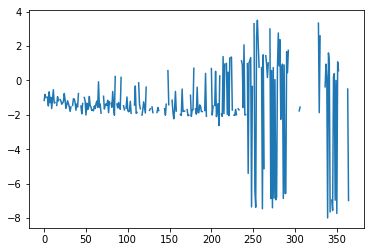

In [66]:
track_sorted[abcd].query('kilo==10000').reset_index()['lev_l'].plot()

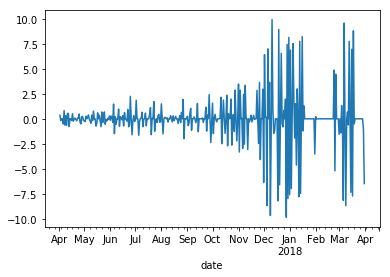

In [67]:
lev_df[abcd].diff().iloc[:,0].plot()